In [172]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import argparse
import mne
import mne_bids
from mne_bids import BIDSPath,print_dir_tree,make_report,make_dataset_description,config
print(dir(mne_bids.config))

import os
print(os.getcwd())

import sys
print(sys.executable) #verify the Python virtual environment (venv) currently used by the Jupyter notebook
print(sys.path)


!matplotlib.use('Qt5Agg')#Ensure Matplotlib uses the `Qt5Agg` backend, which is the best choice for MNE-Python's interactive plotting functions. 
!%matplotlib qt #For some system you might want to use  


config_validation = 'warn'


['ALLOWED_DATATYPES', 'ALLOWED_DATATYPE_EXTENSIONS', 'ALLOWED_FILENAME_EXTENSIONS', 'ALLOWED_FILENAME_SUFFIX', 'ALLOWED_INPUT_EXTENSIONS', 'ALLOWED_PATH_ENTITIES', 'ALLOWED_PATH_ENTITIES_SHORT', 'ALLOWED_SPACES', 'ANNOTATIONS_TO_KEEP', 'ANONYMIZED_JSON_KEY_WHITELIST', 'BIDS_COORDINATE_UNITS', 'BIDS_COORD_FRAME_DESCRIPTIONS', 'BIDS_EEG_COORDINATE_FRAMES', 'BIDS_IEEG_COORDINATE_FRAMES', 'BIDS_MEG_COORDINATE_FRAMES', 'BIDS_SHARED_COORDINATE_FRAMES', 'BIDS_STANDARD_TEMPLATE_COORDINATE_SYSTEMS', 'BIDS_TO_MNE_FRAMES', 'BIDS_VERSION', 'CONVERT_FORMATS', 'DOI', 'EEG_CONVERT_FORMATS', 'ENTITY_VALUE_TYPE', 'EPHY_ALLOWED_DATATYPES', 'EXT_TO_UNIT_MAP', 'FIFF', 'HAND_BIDS_TO_MNE', 'HAND_MNE_TO_BIDS', 'IEEG_CONVERT_FORMATS', 'IGNORED_CHANNELS', 'MANUFACTURERS', 'MEG_CONVERT_FORMATS', 'MNE_FRAME_TO_STR', 'MNE_STR_TO_FRAME', 'MNE_TO_BIDS_FRAMES', 'NIRS_CONVERT_FORMATS', 'ORIENTATION', 'PYBV_VERSION', 'REFERENCES', 'SEX_BIDS_TO_MNE', 'SEX_MNE_TO_BIDS', 'SUFFIX_TO_DATATYPE', 'UNITS_MNE_TO_BIDS_MAP', '__

In [215]:
def change_channel_type(raw):
    '''Change the 'PHOTO' channel to 'stim'. This function will also return the data of the 'PHOTO' channel'''
    if 'PHOTO' in raw.ch_names:
        raw.set_channel_types({'PHOTO': 'stim'})
        stim_data = raw.copy().pick_channels(['PHOTO']).get_data()
        return stim_data
    else:
        return None
    


def change_cropped_channel_type(raw, event_id, onset_event, offset_event):
    '''Change the 'PHOTO' channel to 'stim'. This function will also return the cropped data of the 'PHOTO' channel'''

    if 'PHOTO' in raw.ch_names:
        # Get the events associated with dmstart and dmstop
        events, _ = mne.events_from_annotations(raw)
        onset_event_time = events[events[:,2] == event_id[f'1000, {onset_event}'],0][0] / raw.info['sfreq']
        offset_event_time = events[events[:,2] == event_id[f'1000, {offset_event}'],0][-1] / raw.info['sfreq']

        print(f"onset_event_time: {onset_event_time}, offset_event_time: {offset_event_time}, total duration: {raw.times[-1]}")

        # Crop the data of the 'PHOTO' channel
        stim_data = raw.copy().crop(tmin=onset_event_time, tmax=offset_event_time).pick_channels(['PHOTO']).get_data()

        # Change the channel type to 'stim'
        raw.set_channel_types({'PHOTO': 'stim'})

        return stim_data
    else:
        return None

    


def process_subject(bids_path,onset_event,offset_event):
    '''
    Return the cropped Raw object to use for further processing
    '''
    raw_bids = mne_bids.read_raw_bids(bids_path)
    
    # Obtain events and event_id mapping
    events, event_id = mne.events_from_annotations(raw_bids)
    # print(events)
    print(event_id[f'1000, {onset_event}'])
          
    # Get the onset time for 'eegstart' and 'eegstop' events
    onset_event_time = events[events[:,2] == event_id[f'1000, {onset_event}'],0][0] / raw_bids.info['sfreq']
    offset_event_time = events[events[:,2] == event_id[f'1000, {offset_event}'],0][-1] / raw_bids.info['sfreq']
    # events[event_id[f'1000, {offset_event}'], 0] / raw_bids.info['sfreq']

    # Crop the raw data
    raw_bids.crop(tmin=onset_event_time, tmax=offset_event_time)
    
    # Preload the data into memory after cropping
    raw_bids.load_data()
    
    if bids_path.datatype=='eeg':
        if 'PHOTO' in raw_bids.info['ch_names']:
            stim_data = raw_bids.copy().pick_channels(['PHOTO']).get_data() 
            raw_bids.drop_channels(['PHOTO'])
            info = mne.create_info(['STIM'], raw_bids.info['sfreq'], ['stim'])
            stim_raw = mne.io.RawArray(stim_data, info)
            raw_bids.add_channels([stim_raw], force_update_info=True)

    return raw_bids




## Read the raw data

In [216]:

subjects = ['1','2','3']
metaproject_name = 'Dreamachine_META'
subproject_name = 'preprocessing/MNE_BIDS_pipeline'
dataset = 'ScienceDay27_Session3'
task = 'ScienceDay27'
suffix='eeg'
session = '1'

PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')



# Set the BIDS root
bids_root = os.path.join(PROJDIR,f'DATA/{dataset}/BIDS/')
deriv_root = os.path.expanduser(f"~/projects/{metaproject_name}/DATA/{dataset}/derivatives/mne-bids-pipeline") #path where process output will be stored

# print_dir_tree(bids_root,max_depth=4)
print(mne_bids.make_report(bids_root,task))

Summarizing participants.tsv /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/participants.tsv...
The participant template found: sex were all unknown;
handedness were all unknown;
ages all unknown
This dataset was created by [Unspecified] and conforms to BIDS version 1.7.0.
This report was generated with MNE-BIDS (https://doi.org/10.21105/joss.01896).
The dataset consists of 3 participants (sex were all unknown; handedness were
all unknown; ages all unknown) and 1 recording sessions: 1.


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/960848377.py:19: RuntimeWarning: No *scans.tsv files found. Currently, we do not generate a report without the scans.tsv files.
  print(mne_bids.make_report(bids_root,task))


In [218]:
stim_data = None

# Identify the subject with the stimulus data
for subject in subjects:
    bids_path = BIDSPath(root=bids_root,subject=subject,session=session, task=task, suffix=suffix)
    # raw_bids = process_subject(bids_path=bids_path,onset_event='eegstart',offset_event='eegstop')
    raw_bids = process_subject(bids_path=bids_path,onset_event='eegstart',offset_event='eegstop')
    # raw_bids = mne_bids.read_raw_bids(bids_path=bids_path) 
    raw_bids.load_data() #need to load the data into memory before you can add channels to the Raw object

    events, event_id = mne.events_from_annotations(raw_bids)

    if len(raw_bids.ch_names) == 33:  
        # stim_data = change_channel_type(raw_bids) #changes the type of 'PHOTO' channel to 'stim' and stores its data in stim_data
        stim_data = change_cropped_channel_type(raw_bids,event_id, 'dmstart', 'dmstop') #changes the type of 'PHOTO' channel to 'stim' and stores its data in stim_data
        break #no need to check other subjects

# Process all subjects
for subject in subjects:
    bids_path = BIDSPath(root=bids_root,subject=subject,session=session, task=task, suffix=suffix)
    raw_bids = mne_bids.read_raw_bids(bids_path=bids_path)
    raw_bids.load_data() 

    if len(raw_bids.ch_names) == 32 and stim_data is not None:
        info = mne.create_info(['STIM'], raw_bids.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        raw_bids.add_channels([stim_raw], force_update_info=True) # adds a new 'STIM' channel with the data stored in stim_data

    eeg_chs = [ch for ch in raw_bids.info['ch_names'] if (raw_bids.info['chs'][raw_bids.ch_names.index(ch)]['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH)]
    stim_chs = [ch for ch in raw_bids.info['ch_names'] if (raw_bids.info['chs'][raw_bids.ch_names.index(ch)]['kind'] == mne.io.constants.FIFF.FIFFV_STIM_CH)]

    print(f"For subject {subject}:")
    print(f"Number of EEG channels: {len(eeg_chs)}")
    print(f"EEG channels: {eeg_chs}")
    print(f"Number of STIM channels: {len(stim_chs)}")
    print(f"STIM channels: {stim_chs}\n")

Extracting parameters from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-1/ses-1/eeg/sub-1_ses-1_task-ScienceDay27_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-1/ses-1/eeg/sub-1_ses-1_task-ScienceDay27_events.tsv.
Reading channel info from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-1/ses-1/eeg/sub-1_ses-1_task-ScienceDay27_channels.tsv.
Reading electrode coords from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-1/ses-1/eeg/sub-1_ses-1_space-CapTrak_electrodes.tsv.
Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']
10004
Reading 0 ... 1804023  =      0.000 ...  1761.741 secs...


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/715965419.py:40: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
  raw_bids = mne_bids.read_raw_bids(bids_path)


Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']
Extracting parameters from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-2/ses-1/eeg/sub-2_ses-1_task-ScienceDay27_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-2/ses-1/eeg/sub-2_ses-1_task-ScienceDay27_events.tsv.
Reading channel info from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-2/ses-1/eeg/sub-2_ses-1_task-ScienceDay27_channels.tsv.
Reading electrode coords from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-2/ses-1/eeg/sub-2_ses-1_space-CapTrak_electrodes.tsv.
Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, st

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/715965419.py:40: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
  raw_bids = mne_bids.read_raw_bids(bids_path)


Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']
Extracting parameters from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_events.tsv.
Reading channel info from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_channels.tsv.
Reading electrode coords from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_space-CapTrak_electrodes.tsv.
Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, st

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/715965419.py:40: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'PHOTO']
  raw_bids = mne_bids.read_raw_bids(bids_path)


Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']
Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']
onset_event_time: 430.1103515625, offset_event_time: 1620.2099609375, total duration: 1761.3271484375
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting parameters from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-1/ses-1/eeg/sub-1_ses-1_task-ScienceDay27_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-1/ses-1/eeg/sub-1_ses-1_task-ScienceDay27_events.tsv.
Reading channel info from /Users/rb666/

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/4170173360.py:21: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
  raw_bids = mne_bids.read_raw_bids(bids_path=bids_path)


Creating RawArray with float64 data, n_channels=1, n_times=1218663
    Range : 0 ... 1218662 =      0.000 ...  1190.100 secs
Ready.


ValueError: All data dimensions except channels must match, got [1835920] != [1218663]

In [177]:
sessions = mne_bids.get_entity_vals(bids_root, 'session', ignore_sessions='on')
extensions = [".tsv"]  # ignore .json files

# Retrieve a list of all EEG-related files in the dataset for ALL sessions :
bids_paths = mne_bids.find_matching_paths(bids_root, datatypes=suffix,
                                 sessions=sessions, extensions=extensions)

# Retrieve a list of all EEG-related files in the dataset for ONE session only
bids_paths = BIDSPath(root=bids_root, session=session, task=task, datatype=suffix) #paths for all subjects
# print(bids_paths.match(ignore_json=True))

In [91]:
subject = '3'

bids_path = bids_paths.update(subject=subject, task=task, suffix=suffix)
print(bids_path)


# bids_path = BIDSPath(subject=subject, session=session, task='ScienceDay27',datatype='eeg', root=bids_root)
raw_bids = mne_bids.read_raw_bids(bids_path=bids_path)
raw_bids.info

/Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_eeg.vhdr
Extracting parameters from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_events.tsv.
Reading channel info from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_task-ScienceDay27_channels.tsv.
Reading electrode coords from /Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/BIDS/sub-3/ses-1/eeg/sub-3_ses-1_space-CapTrak_electrodes.tsv.


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/1753618999.py:10: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'PHOTO']
  raw_bids = mne_bids.read_raw_bids(bids_path=bids_path)


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 33 EEG
 custom_ref_applied: False
 dig: 33 items (33 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 3 items (dict)
>

## Let's visualize the raw data!

Using matplotlib as 2D backend.


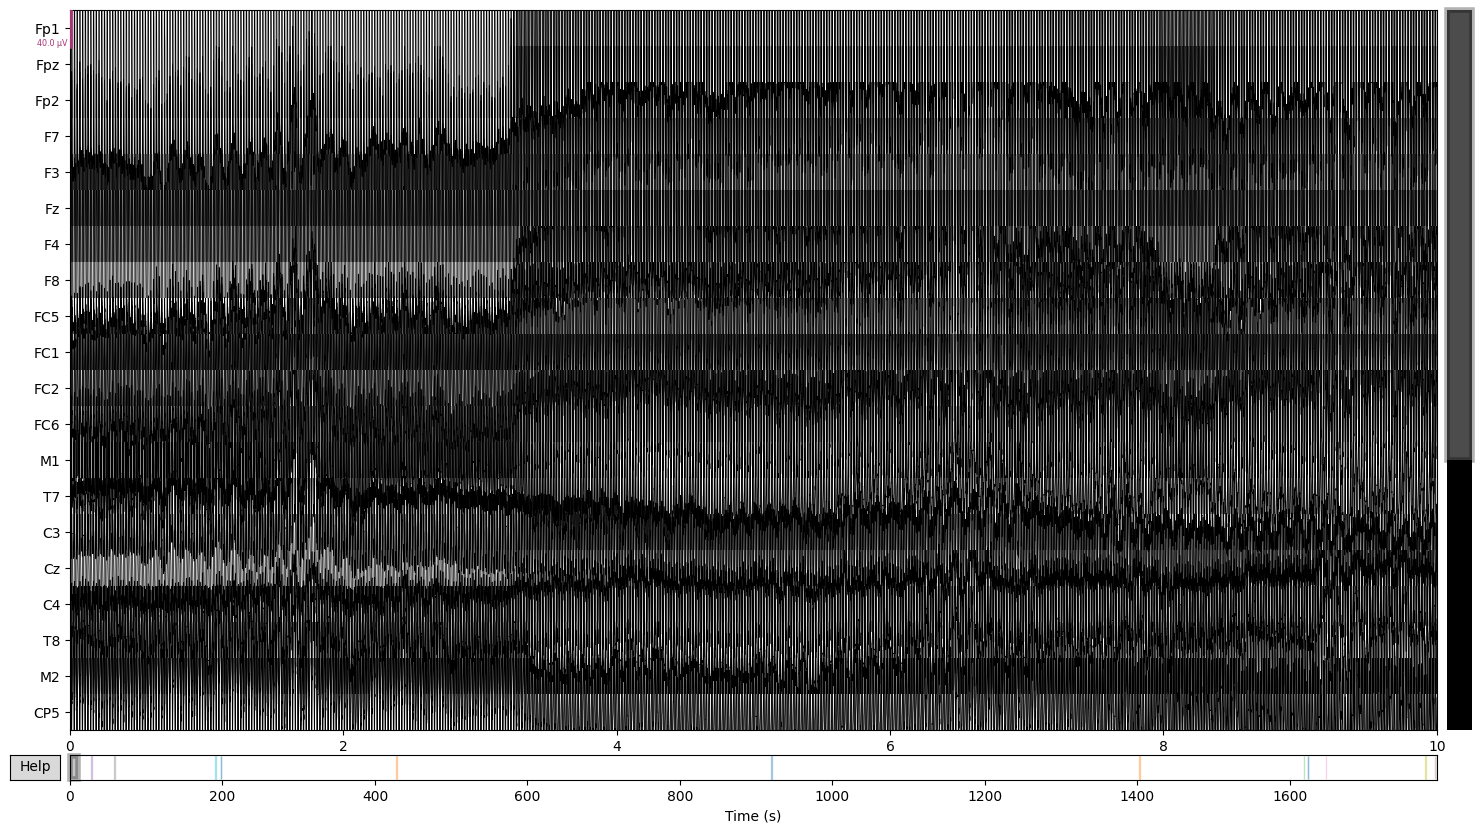

In [29]:
raw_bids.plot();

## Extract events from the `STIM` channels

In this experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.

We can extract information about the events in this task from the raw data.

In [92]:
raw_bids.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [124]:
available_infos = [key for key in raw_bids.info.keys() if raw_bids.info[key]!=None] #list of 
print('Available key informations from data : ',available_infos)

data_description = dict()
# for key in Lraw.info.keys():
for key in available_infos:
    data_description[key]=raw_bids.info[key]
# data_description

print(raw_bids.info['subject_info'])
print(raw_bids.info['line_freq']) #power line frequency
print(raw_bids.info['proc_history'])
print(raw_bids.info['nchan'])
print(raw_bids.info['events'])
print(raw_bids.info['sfreq']) #sampling frequency

chan_list = raw_bids.info['ch_names']
print(chan_list)

Available key informations from data :  ['dig', 'highpass', 'lowpass', 'subject_info', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan']
{'his_id': 'sub-3', 'sex': 0, 'hand': 0}
None
[]
33
[]
1024.0
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'PHOTO']


In [94]:
#Events are loaded from annotations
print(len(raw_bids.annotations))
print(set(raw_bids.annotations.duration))
print(set(raw_bids.annotations.description))
print(raw_bids.annotations.onset[0])

16
{0.0, 1.0}
{'1000, stoppost', '1000, startpre', '1000, stoppre', '1000, eegstart', '1000, startpost', '1000, synch2', '0, Impedance', '1000, eegstop', '1000, dmstop', '1000, dmstart', '1000, synch1'}
30.311523


In [95]:
#https://mne.tools/stable/auto_tutorials/intro/20_events_from_raw.html#sphx-glr-auto-tutorials-intro-20-events-from-raw-py
raw_bids.annotations.description
events_from_annot, event_dict = mne.events_from_annotations(raw_bids)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']
{'0, Impedance': 10001, '1000, dmstart': 10002, '1000, dmstop': 10003, '1000, eegstart': 10004, '1000, eegstop': 10005, '1000, startpost': 10006, '1000, startpre': 10007, '1000, stoppost': 10008, '1000, stoppre': 10009, '1000, synch1': 10010, '1000, synch2': 10011}
[[ 31039      0  10004]
 [ 62161      0  10007]
 [197517      0  10009]
 [204880      0  10001]
 [204880      0  10001]]


In [96]:
mne.find_events(raw_bids)

ValueError: No stim channels found, but the raw object has annotations. Consider using mne.events_from_annotations to convert these to events.

Six events have been identified, we can label them according to the task paradigm.

In [87]:
event_id = {
    'eegstart': 1,
    'startpre': 2,
    'stoppre': 3,
    'dmstart': 4,
    'synch1': 5,
    'synch2': 6,
    'dmstop':7,
    'startpost':8,
    'stoppost':9,
    'eegstop':10
}
event_id

events_path = "/Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/events/CS_PD_events.txt"
events_txt = mne.read_events(events_path)
events_txt

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/190919232.py:16: RuntimeWarning: This filename (/Users/rb666/projects/Dreamachine_META/DATA/ScienceDay27_Session3/events/CS_PD_events.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events_txt = mne.read_events(events_path)


ValueError: could not convert string 'number' to float64 at row 0, column 1.

In [101]:
event_id

{'eegstart': 1,
 'startpre': 2,
 'stoppre': 3,
 'dmstart': 4,
 'synch1': 5,
 'synch2': 6,
 'dmstop': 7,
 'startpost': 8,
 'stoppost': 9,
 'eegstop': 10}

We can plot when these events take place in time in the task paradigm

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_87286/1601543872.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events_from_annot, event_id=event_dict, sfreq=raw_bids.info['sfreq']);


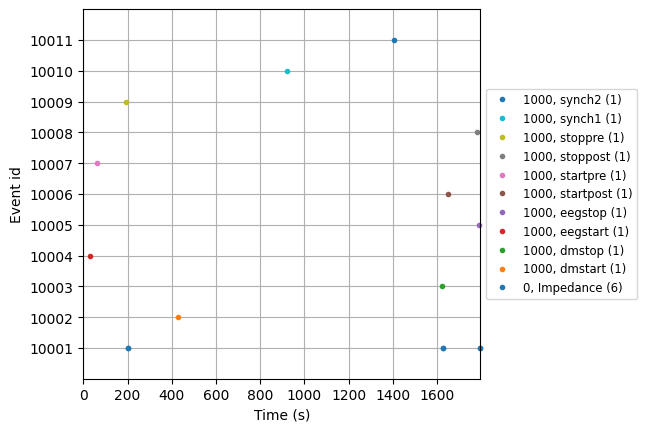

In [102]:
#rename events to plot
from mne.viz import plot_events
mne.viz.plot_events(events_from_annot, event_id=event_dict, sfreq=raw_bids.info['sfreq']);

In [135]:
events_from_annot, event_dict = mne.events_from_annotations(raw_bids)
# print(event_dict)
# print(events_from_annot[:5])
event_dict

Used Annotations descriptions: ['0, Impedance', '1000, dmstart', '1000, dmstop', '1000, eegstart', '1000, eegstop', '1000, startpost', '1000, startpre', '1000, stoppost', '1000, stoppre', '1000, synch1', '1000, synch2']


{'0, Impedance': 10001,
 '1000, dmstart': 10002,
 '1000, dmstop': 10003,
 '1000, eegstart': 10004,
 '1000, eegstop': 10005,
 '1000, startpost': 10006,
 '1000, startpre': 10007,
 '1000, stoppost': 10008,
 '1000, stoppre': 10009,
 '1000, synch1': 10010,
 '1000, synch2': 10011}

In [139]:
raw_bids.plot(events=events_from_annot,highpass=1,lowpass=30,ch_names="PHOTO")

TypeError: BaseRaw.plot() got an unexpected keyword argument 'ch_names'

In [158]:
raw_PD = raw_bids.copy().pick_channels(['PHOTO']) #contains only activity of the photodiode (PD) channel 
PD_infos = raw_PD.info['chs'][0]
print(PD_infos)

# mne.viz.plot_raw(raw_bids.pick_channels(['PHOTO']),scalings='auto') #,lowpass=30,highpass=1,scalings='auto')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
{'ch_name': 'PHOTO', 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'logno': 33, 'scanno': 33, 'cal': 0.1, 'range': 1e-06, 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit': 107 (FIFF_UNIT_V), 'unit_mul': 0 (FIFF_UNITM_NONE), 'coord_frame': 4 (FIFFV_COORD_HEAD)}


## Plot the raw data again, but add event markers

## Gather some info about the data

In [162]:
raw_bids.info

<Info | 9 non-empty values
 bads: []
 ch_names: PHOTO
 chs: 1 EEG
 custom_ref_applied: False
 dig: 33 items (33 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 3 items (dict)
>

In [23]:
raw_bids.info.keys()

dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'device_info', 'helium_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'utc_offset', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id'])

In [161]:
raw_bids.info['meas_date']

In [25]:
raw.info['sfreq']

600.614990234375

In [26]:
#Identify bad channels labbeled during acquisition
raw.info['bads']

['MEG 2443', 'EEG 053']

In [27]:
#We can also call specific channels and their properties
raw.info['chs'][0]

{'scanno': 1,
 'logno': 113,
 'kind': 1 (FIFFV_MEG_CH),
 'range': 0.00030517578125,
 'cal': 3.1600000394149674e-09,
 'coil_type': 3012 (FIFFV_COIL_VV_PLANAR_T1),
 'loc': array([-0.1066    ,  0.0464    , -0.0604    , -0.0127    ,  0.0057    ,
        -0.99990302, -0.186801  , -0.98240298, -0.0033    , -0.98232698,
         0.18674099,  0.013541  ]),
 'unit': 201 (FIFF_UNIT_T_M),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'MEG 0113',
 'coord_frame': 1 (FIFFV_COORD_DEVICE)}

## Select only a subset of the channels

In [28]:
raw_eeg = raw.copy()
raw_eeg.pick_types(meg=False, eeg=True, eog=True, exclude=[])
len(raw_eeg.ch_names)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


61

In [29]:
raw_eeg.plot(events=events, event_id=event_id);

Channels marked as bad:
['EEG 053']


## Visualize the sensor locations

In [30]:
#In 2D
raw.plot_sensors(ch_type='eeg');

In [31]:
#In 3D
raw.plot_sensors(kind='3d', ch_type='eeg');

## Mark channels as bad

Mark an additional EEG channel as bad and view the topoplot.

In [32]:
raw.info['bads']

['MEG 2443', 'EEG 053']

In [33]:
raw.info['bads'] += ['EEG 051']
raw.plot_sensors(ch_type='eeg');
raw.plot_sensors(kind = '3d',ch_type='eeg');

# Cropping and filtering the data

## Cropping

This EEG datset contains around 278 seconds of data. We can use only the first 100 seconds for analysis by cropping the data.

In [34]:
raw.times[-1]

277.7136813300495

It's best to make a copy of the loaded data first before cropping.

In [37]:
raw_cropped = raw.copy()
raw_cropped = raw_cropped.crop(tmax=100)
raw_cropped.times[-1]

99.99916914588277

## Filtering

We can also filter to get a specific frequency range

When we plot the power spectrum we can see frequencies ranging upto 300 Hz. 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


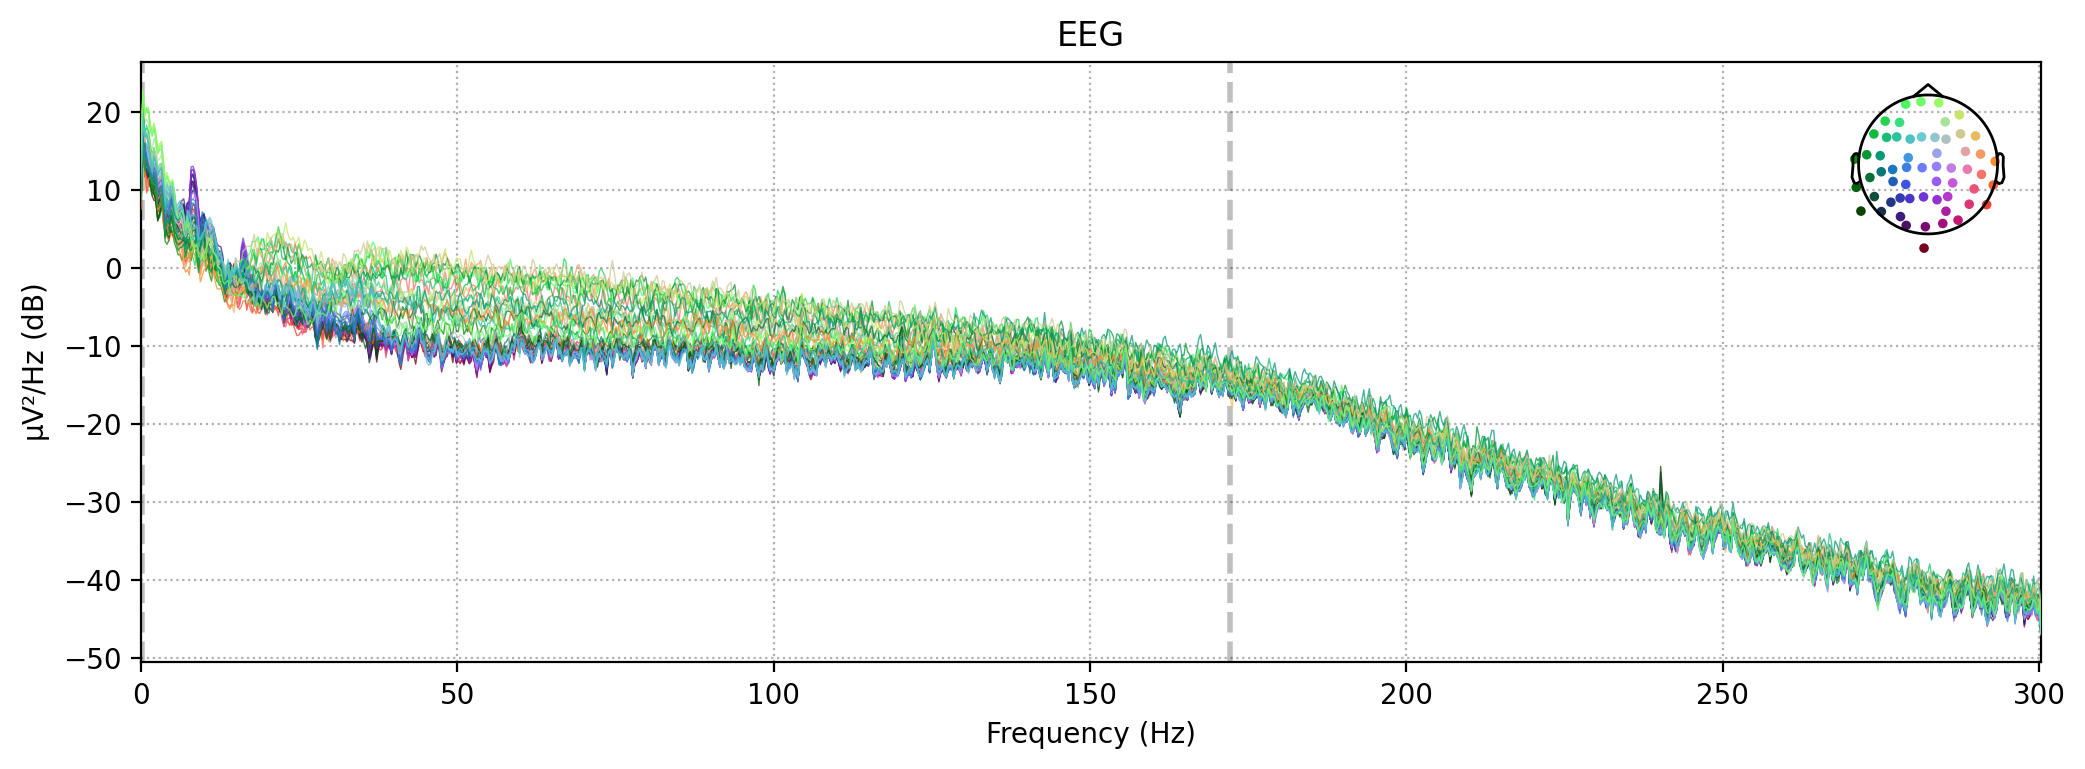

In [38]:
raw_cropped.plot_psd(picks=['eeg'])

Let's say we only want to look at signals between 0.1 and 40 Hz to focus only on some of the brain-related activity.

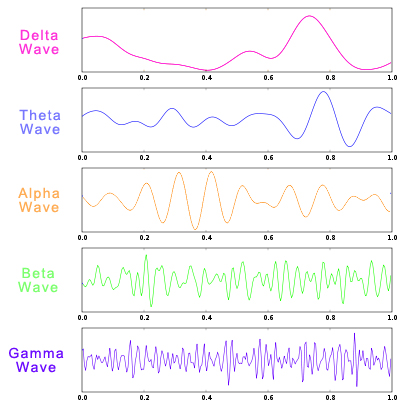

In [39]:
#Crop using a band pass filter from 1-40 Hz
raw_cropped_filtered = raw_cropped.copy()
raw_cropped_filtered = raw_cropped_filtered.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.3s finished


### Compare before and after

In [42]:
fig, ax = plt.subplots(2, figsize=(10,5))
raw_cropped.plot_psd(ax=ax[0],picks=['eeg'], show = False)
raw_cropped_filtered.plot_psd(ax=ax[1],picks=['eeg'], show = False)

ax[0].set_title('PSD before filtering')
ax[1].set_title('PSD after filtering')
ax[1].set_xlabel('Frequency (Hz)')
fig.set_tight_layout(True)
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)


/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_31284/4016148849.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.show()


KeyboardInterrupt: 

### Zoom in

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.426 (s)


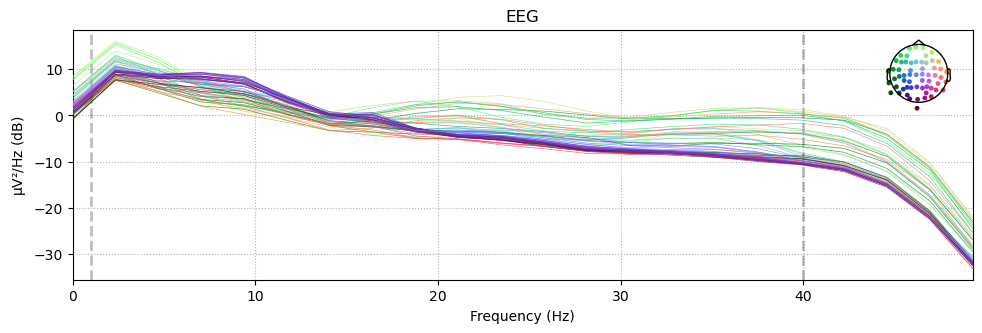

In [37]:
raw_cropped_filtered.plot_psd(picks=['eeg'], fmax=50)

# Saving the data in BIDS format


Neuroimaging experiments result in complicated data that can be arranged in many different ways. So far there is no consensus how to organize and share data obtained in neuroimaging experiments. Even two researchers working in the same lab can opt to arrange their data in a different way. Lack of consensus (or a standard) leads to misunderstandings and time wasted on rearranging data or rewriting scripts expecting certain structure.

BIDS, the Brain Imaging Data Structure, is a standard that describes how to organize neuroimaging and electrophysiological data. In particular, it defines:



*   which file formats to use
*   how to name your files
* where to place your files within a directory structure
* what additional metadata to store

The complete set of rules is written down in the [BIDS specification](https://bids-specification.readthedocs.io/en/stable/).

Here we use an extension to BIDS for electroencephalography (EEG) data, **EEG-BIDS**.

**[MNE-BIDS](https://mne.tools/mne-bids/stable/index.html)** is a Python package that allows you to read and write BIDS-compatible datasets with the help of MNE-Python.

## Write the raw data to BIDS!

We need to specify the power line frequency.

In [43]:
raw.info

<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 3 items (MEG 2443, EEG 053, EEG 051)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

In [44]:
#First, we need to specify the power line frequency as that is not included in the raw info

raw_cropped_filtered.info['line_freq'] = 60

#Set the path to where it will be saved
out_path = pathlib.Path('out_data/sample_BIDS')

#Set path with data specific variables for naming directory files
bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='audiovisual',
                              run='01',
                              root=out_path)
#Write raw to BIDS!
mne_bids.write_raw_bids(raw_cropped_filtered, bids_path=bids_path, events_data=events,
                        event_id=event_id, overwrite=True,format= 'FIF',allow_preload=True )

Writing 'out_data/sample_BIDS/README'...
Writing 'out_data/sample_BIDS/participants.tsv'...
Writing 'out_data/sample_BIDS/participants.json'...
Writing 'out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_coordsystem.json'...
Writing 'out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_coordsystem.json'...
Used Annotations descriptions: ['Auditory/Left', 'Auditory/Right', 'Button', 'Smiley', 'Visual/Left', 'Visual/Right']
Writing 'out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_events.tsv'...
Writing 'out_data/sample_BIDS/dataset_description.json'...
Writing 'out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_meg.json'...
Writing 'out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_channels.tsv'...
Copying data files to sub-01_ses-01_task-audiovisual_run-01_meg.fif
Reserving possible split file sub-01_ses-01_task-audiovisual_run-01_split-01_meg.fif
Writing /Users/rb666/brainhack/mne_eeg_workshop/out_data/

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_31284/182445921.py:15: FutureWarning: The events_data parameter has been deprecated in favor the new events parameter, to ensure better consistency  with MNE-Python. The events_data parameter will be removed in MNE-BIDS 0.14. Please use the events parameter instead.
  mne_bids.write_raw_bids(raw_cropped_filtered, bids_path=bids_path, events_data=events,
/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_31284/182445921.py:15: RuntimeWarning: Omitted 173 annotation(s) that were outside data range.
  mne_bids.write_raw_bids(raw_cropped_filtered, bids_path=bids_path, events_data=events,


Closing /Users/rb666/brainhack/mne_eeg_workshop/out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_meg.fif
[done]
Writing 'out_data/sample_BIDS/sub-01/ses-01/sub-01_ses-01_scans.tsv'...
Wrote out_data/sample_BIDS/sub-01/ses-01/sub-01_ses-01_scans.tsv entry with meg/sub-01_ses-01_task-audiovisual_run-01_meg.fif.


BIDSPath(
root: out_data/sample_BIDS
datatype: meg
basename: sub-01_ses-01_task-audiovisual_run-01_meg.fif)

### Print the created file & directory structure

In [45]:
mne_bids.print_dir_tree(out_path)

|sample_BIDS/
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-01/
|------ ses-01/
|--------- sub-01_ses-01_scans.tsv
|--------- meg/
|------------ sub-01_ses-01_coordsystem.json
|------------ sub-01_ses-01_task-audiovisual_run-01_channels.tsv
|------------ sub-01_ses-01_task-audiovisual_run-01_events.tsv
|------------ sub-01_ses-01_task-audiovisual_run-01_meg.fif
|------------ sub-01_ses-01_task-audiovisual_run-01_meg.json


### Generate a data summary

In [46]:
print(mne_bids.make_report(out_path))

Summarizing participants.tsv out_data/sample_BIDS/participants.tsv...
Summarizing scans.tsv files [PosixPath('out_data/sample_BIDS/sub-01/ses-01/sub-01_ses-01_scans.tsv')]...
The participant template found: sex were all unknown;
handedness were all unknown;
ages all unknown
This dataset was created by [Unspecified] and conforms to BIDS version 1.7.0.
This report was generated with MNE-BIDS (https://doi.org/10.21105/joss.01896).
The dataset consists of 1 participants (sex were all unknown; handedness were
all unknown; ages all unknown) and 1 recording sessions: 01. Data was recorded
using an MEG system (Elekta) sampled at 600.61 Hz with line noise at 60.0 Hz.
The following software filters were applied during recording:
SpatialCompensation. There was 1 scan in total. Recording durations ranged from
100.0 to 100.0 seconds (mean = 100.0, std = 0.0), for a total of 100.0 seconds
of data recorded over all scans. For each dataset, there were on average 376.0
(std = 0.0) recording channels pe

## Reading BIDS data

In [47]:
bids_root = pathlib.Path('out_data/sample_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='audiovisual',
                              run='01',
                              datatype='meg',
                              root=bids_root)

raw_BIDS = mne_bids.read_raw_bids(bids_path)
raw_BIDS.plot();

Opening raw data file out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_meg.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 85861 =     42.956 ...   142.955 secs
Ready.
Reading events from out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_events.tsv.
Reading channel info from out_data/sample_BIDS/sub-01/ses-01/meg/sub-01_ses-01_task-audiovisual_run-01_channels.tsv.
Channels marked as bad:
['MEG 2443', 'EEG 051', 'EEG 053']


# Refrences

**MNE-Python** - 
Alexandre Gramfort, Martin Luessi, Eric Larson, Denis A. Engemann, Daniel Strohmeier, Christian Brodbeck, Roman Goj, Mainak Jas, Teon Brooks, Lauri Parkkonen, and Matti S. Hämäläinen. MEG and EEG data analysis with MNE-Python. Frontiers in Neuroscience, 7(267):1–13, 2013. doi:10.3389/fnins.2013.00267.

**BIDS**
Gorgolewski, K.J., Auer, T., Calhoun, V.D., Craddock, R.C., Das, S., Duff, E.P., Flandin, G., Ghosh, S.S., Glatard, T., Halchenko, Y.O., Handwerker, D.A., Hanke, M., Keator, D., Li, X., Michael, Z., Maumet, C., Nichols, B.N., Nichols, T.E., Pellman, J., Poline, J.-B., Rokem, A., Schaefer, G., Sochat, V., Triplett, W., Turner, J.A., Varoquaux, G., Poldrack, R.A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. Scientific Data, 3 (160044). doi:10.1038/sdata.2016.44

**MNE-BIDS** - 
Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A., & Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. *Journal of Open Source Software*, 4:1896. DOI: 10.21105/joss.01896

**EEG-BIDS** - Pernet, C. R., Appelhoff, S., Gorgolewski, K.J., Flandin, G., Phillips, C., Delorme, A., Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific data, 6 (103). doi:10.1038/s41597-019-0104-8

**MNE EEG-BIDS**
Niso, G., Gorgolewski, K., Bock, E. et al. MEG-BIDS, the brain imaging data structure extended to magnetoencephalography. *Sci Data* 5, 180110 (2018). https://doi.org/10.1038/sdata.2018.110



## Exercise #1

1) How many channels do you have for each type of sensors?


In [72]:
print(raw.info.keys())
print(raw.info['nchan'])
nchan_MEG = len([chan for chan in raw.info['ch_names'] if chan.startswith('MEG')])
nchan_EEG = len([chan for chan in raw.info['ch_names'] if chan.startswith('EEG')])
nchan_EOG = len([chan for chan in raw.info['ch_names'] if chan.startswith('EOG')])
print(' EEG chans : {}\n MEG chans : {}\n EOG chans : {}'.format(nchan_EEG,nchan_MEG,nchan_EOG))


dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'device_info', 'helium_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'utc_offset', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id'])
376
 EEG chans : 60
 MEG chans : 306
 EOG chans : 1


2) What is the sampling frequency?

In [75]:
print(raw.info['sfreq'])

600.614990234375


3) Have the data been filtered?

In [78]:
raw.info['proc_history']

[]

4) What is the frequency of the line noise?

In [76]:
print(raw.info['line_freq'])

None


5) Is there any bad channel?

In [77]:
print(raw.info['bads'])

['MEG 2443', 'EEG 053', 'EEG 051']
